In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import os
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, BatchNormalization, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import metrics
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from itertools import chain
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akinmade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Pre-processing and Cleaning

In [3]:
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# importing the amazon reviews datafile and selecting the needed columns
df = pd.read_csv("Reviews.csv")
df = df[['Score','Summary', 'Text']]

# Engineering the sentiment feature from the score column
df['Sentiment'] = df["Score"].apply(lambda x: 1 if x > 2 else 0)
df_mod = df[['Text', 'Sentiment']].copy()
df_mod.head(50)

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
5,I got a wild hair for taffy and ordered this f...,1
6,This saltwater taffy had great flavors and was...,1
7,This taffy is so good. It is very soft and ch...,1
8,Right now I'm mostly just sprouting this so my...,1
9,This is a very healthy dog food. Good for thei...,1


In [5]:
# defining a function to carry out exploratory data analysis on the null and missing values in the data
def info(data_fr):
    for col in data_fr.columns:
       # print(col ,': ',data_fr[col].value_counts())
        print(col ,'total values: ',len(data_fr[col]))
        print(col ,'null values: ',data_fr[col].isna().sum())
        print(col ,'non-null values: ',data_fr[col].notnull().sum())
        print('is unique: ', data_fr[col].nunique()/len(data_fr[col]))
        print(col ,'duplicate values: ', (len(data_fr[col]) - data_fr[col].nunique()))
        print('\n')

In [6]:
info(df)

Score total values:  568454
Score null values:  0
Score non-null values:  568454
is unique:  8.795786466451111e-06
Score duplicate values:  568449


Summary total values:  568454
Summary null values:  27
Summary non-null values:  568427
is unique:  0.5202566962322369
Summary duplicate values:  272712


Text total values:  568454
Text null values:  0
Text non-null values:  568454
is unique:  0.6923673683358724
Text duplicate values:  174875


Sentiment total values:  568454
Sentiment null values:  0
Sentiment non-null values:  568454
is unique:  3.5183145865804446e-06
Sentiment duplicate values:  568452




In [7]:
#dropping the summary columnn to allow us focus on just the text feature we would be working with
df.dropna(subset = ['Summary'], inplace = True)
info(df_mod)

Text total values:  568454
Text null values:  0
Text non-null values:  568454
is unique:  0.6923673683358724
Text duplicate values:  174875


Sentiment total values:  568454
Sentiment null values:  0
Sentiment non-null values:  568454
is unique:  3.5183145865804446e-06
Sentiment duplicate values:  568452




In [9]:
# shuffling up the dataset to improve diversity of the datafile before splitting
from sklearn.utils import shuffle
df_mod = shuffle(df_mod)

In [10]:
# checking the different number of rows for each label in out target feature
df_mod.Sentiment.value_counts()

1    486417
0     82037
Name: Sentiment, dtype: int64

In [11]:
# creating a list to contain all the texts from our dataframe in preparation for tokenization of the words
lines =[] 
  
# Iterate over each row 
for index, rows in df_mod.iterrows(): 
    # Create list for the current row 
    my_list =str(rows.Text)
      
    # append the list to the final list 
    lines.append(my_list) 
  
# Print the list 
len(lines)

568454

In [12]:
label=list(df_mod['Sentiment'])

In [13]:
# tokenizing the words in the lines list so as to allow the data be usable my our neural network models
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [18]:
sequences = np.array(sequences)
label = np.array(label)

# Modelling

In [19]:
# maually splitting the data into test and train test using a rough 70/30 distribution
x_train=sequences[:390000]
y_train=label[:390000]
x_test=sequences[390000:]
y_test=label[390000:]

In [20]:
# importing keras to preprocess our train and test data by padding them with zero values so each sub-list in them
# contains the same number of elements
maxlen = 100
from keras import preprocessing
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [17]:
#using smote to address data imbalance
smote = SMOTE(random_state=1, k_neighbors=6)

x_train_smote, y_smote = smote.fit_resample(x_train, y_train)


In [21]:
y_df = pd.DataFrame(y_train, columns= ["Sentiment"])
print(y_df["Sentiment"].value_counts())

1    333799
0     56201
Name: Sentiment, dtype: int64


In [22]:
y_sdf = pd.DataFrame(y_smote, columns= ["Sentiment"])
print(y_sdf["Sentiment"].value_counts())

1    333799
0    333799
Name: Sentiment, dtype: int64


   Y train  Y smote
0   333881   333881
1    56119   333881


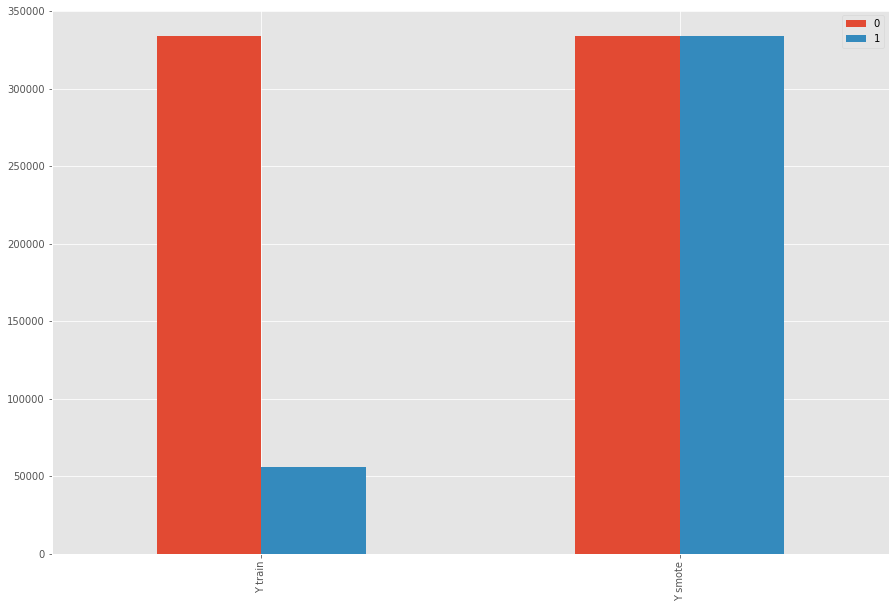

In [23]:
# Creating bargraph to show class distribution of data before and after smote oversampling
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
y_dict = {'Y train': [333881, 56119], 'Y smote': [333881, 333881]}

y_comb = pd.DataFrame(data=y_dict)

print(y_comb)

# plotting the rss values of each feature on the train and test data side by side as a multiple bargraph
style.use('ggplot')
y_comb.T.plot(kind='bar',figsize=(15,10))

## Baseline model - Logistic Regression

In [24]:
# using the logistic regression model to establish a baseline performance our models should surpass
lr_model = LogisticRegression()
lr_model.fit(x_train_smote, y_smote)

# printing out its performance
y_pred_lr = lr_model.predict(x_test)
print (accuracy_score(y_test, y_pred_lr))
print(metrics.classification_report(y_test, y_pred_lr))

0.489112040077555
              precision    recall  f1-score   support

           0       0.14      0.50      0.22     25836
           1       0.85      0.49      0.62    152618

    accuracy                           0.49    178454
   macro avg       0.50      0.49      0.42    178454
weighted avg       0.75      0.49      0.56    178454



## RNN model

In [31]:
# building a simple RNN model with a single dense sigmoid layer to fit our binary class data
from keras.layers import Embedding,SimpleRNN
from keras.layers import Flatten, Dense
from keras.layers import Embedding,SimpleRNN

input_shape = [x_train_smote.shape[1]]

model_rnn = Sequential()
model_rnn.add(Embedding(1000, 32, input_length=maxlen))
model_rnn.add(Dropout(rate=0.3))
model_rnn.add(BatchNormalization())
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dropout(rate=0.3))
model_rnn.add(BatchNormalization())
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_rnn.summary()
history_rnn = model_rnn.fit(x_train_smote, y_smote, epochs=8, batch_size=256, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           32000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 32)           128       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [32]:
# predict crisp classes for test set
rnn_y_classes = model_rnn.predict_classes(x_test, verbose=0)

In [33]:
# obtain performance of RNN model
print(metrics.classification_report(y_test, rnn_y_classes))

              precision    recall  f1-score   support

           0       0.81      0.45      0.58     25836
           1       0.91      0.98      0.95    152618

    accuracy                           0.91    178454
   macro avg       0.86      0.72      0.77    178454
weighted avg       0.90      0.91      0.89    178454



In [78]:
# obtain performance of RNN model
print(metrics.classification_report(y_test, rnn_y_classes))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67     25918
           1       0.94      0.95      0.95    152536

    accuracy                           0.91    178454
   macro avg       0.82      0.80      0.81    178454
weighted avg       0.91      0.91      0.91    178454



## LSTM model

In [34]:
# building a LSTM model with a single dense sigmoid layer to fit our binary class data
model_lstm = Sequential()
model_lstm.add(Embedding(1000, 32, input_length=maxlen))
model_lstm.add(Dropout(rate=0.3))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(rate=0.3))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_lstm.summary()
history_lstm = model_lstm.fit(x_train_smote, y_smote, epochs=8, batch_size=256, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           32000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 32)           128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [35]:
# predict crisp classes for test set
lstm_y_classes = model_lstm.predict_classes(x_test, verbose=0)

In [36]:
# obtain performance of LSTM model
print(metrics.classification_report(y_test, lstm_y_classes))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72     25836
           1       0.94      0.97      0.96    152618

    accuracy                           0.93    178454
   macro avg       0.87      0.81      0.84    178454
weighted avg       0.92      0.93      0.92    178454



In [83]:
# obtain performance of LSTM model
print(metrics.classification_report(y_test, lstm_y_classes))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74     25918
           1       0.95      0.97      0.96    152536

    accuracy                           0.93    178454
   macro avg       0.87      0.84      0.85    178454
weighted avg       0.93      0.93      0.93    178454



## Graphs

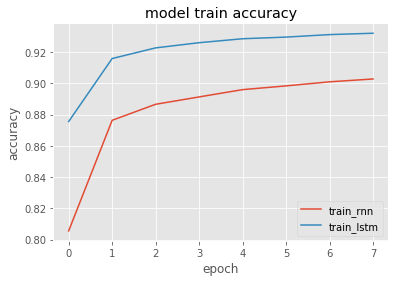

In [45]:
plt.plot(history_rnn.history['acc'])
plt.plot(history_lstm.history['acc'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_rnn', 'train_lstm'], loc='lower right')
plt.show()

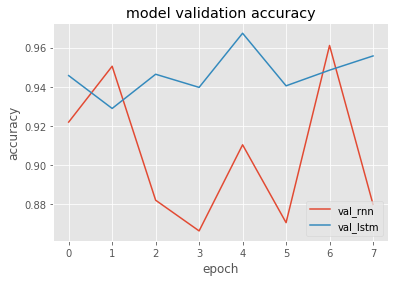

In [46]:
plt.plot(history_rnn.history['val_acc'])
plt.plot(history_lstm.history['val_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_rnn', 'val_lstm'], loc='lower right')
plt.show()

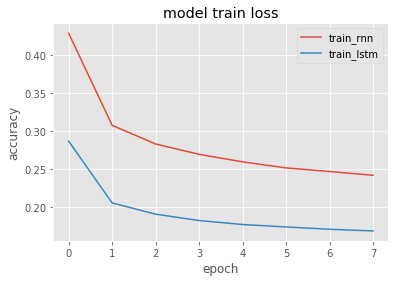

In [48]:
plt.plot(history_rnn.history['loss'])
plt.plot(history_lstm.history['loss'])
plt.title('model train loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_rnn', 'train_lstm'], loc='upper right')
plt.show()

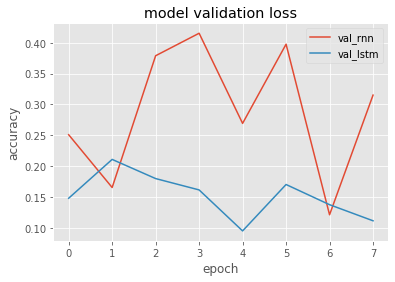

In [50]:
plt.plot(history_rnn.history['val_loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_rnn', 'val_lstm'], loc='upper right')
plt.show()